# Crypto Data Analysis - ITMO MD 2025

Анализ данных криптовалютного рынка

**Данные:**
- `dm.dm_crypto_market_overview` - обзор рынка
- `dm.dm_news_impact_analysis` - влияние новостей
- `ods.ods_binance_daily_agg` - дневные агрегаты
- `ods.ods_news_enriched` - новости с sentiment

In [1]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from datetime import datetime, timedelta
import warnings
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

# Загрузка переменных окружения из .env
load_dotenv()

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Размер фигур по умолчанию
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

/home/toharhymes/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Подключение к БД

In [2]:
# Читаем credentials из .env
conn_params = {
    'host': os.getenv('POSTGRES_HOST', 'localhost'),
    'port': int(os.getenv('POSTGRES_PORT', 5432)),
    'database': os.getenv('POSTGRES_DB', 'analytics'),
    'user': os.getenv('POSTGRES_USER', 'analytics'),
    'password': os.getenv('POSTGRES_PASSWORD', 'analytics')
}

conn = psycopg2.connect(**conn_params)
print("Connected to PostgreSQL")
print(f"Host: {conn_params['host']}:{conn_params['port']}")

def query_to_df(sql):
    return pd.read_sql(sql, conn)

Connected to PostgreSQL
Host: 213.171.30.141:5433


## Как работает sentiment analysis

В DBT модели `ods_news_enriched` используется простой keyword matching:

```sql
case
    when lower(title) similar to '%(bull|bullish|surge|rally|gain|up|rise|positive)%' 
        then 'positive'
    when lower(title) similar to '%(bear|bearish|crash|fall|drop|down|decline|negative)%' 
        then 'negative'
    else 'neutral'
end as sentiment
```

**Ключевые слова:**
- Positive: bull, bullish, surge, rally, gain, up, rise, positive
- Negative: bear, bearish, crash, fall, drop, down, decline, negative
- Neutral: всё остальное

Потом в `dm.dm_news_impact_analysis` считается sentiment_score и агрегация по датам.

In [3]:
# Примеры классификации
news_examples = query_to_df("""
    SELECT 
        title,
        sentiment,
        pub_date_only as date
    FROM ods.ods_news_enriched
    ORDER BY pub_date DESC
    LIMIT 20
""")

print("=== Примеры sentiment ===")
print("\nPositive:")
positive_examples = news_examples[news_examples['sentiment'] == 'positive']
for idx, row in positive_examples.head(3).iterrows():
    print(f"   {row['title'][:80]}...")

print("\nNegative:")
negative_examples = news_examples[news_examples['sentiment'] == 'negative']
for idx, row in negative_examples.head(3).iterrows():
    print(f"   {row['title'][:80]}...")

print("\nNeutral:")
neutral_examples = news_examples[news_examples['sentiment'] == 'neutral']
for idx, row in neutral_examples.head(3).iterrows():
    print(f"   {row['title'][:80]}...")

print("\n=== Статистика ===")
print(news_examples['sentiment'].value_counts())
print(f"Total: {len(news_examples)} новостей")

=== Примеры sentiment ===

Positive:
   Polygon price crashes as transactions rise after Madhugiri hardfork, as expert q...
   Ethereum price prediction: Bulls eye $3,400 while bears watch $2,800...
   Ripple ecosystem upgrade: XRP cross-chain to SOL and ETH, LeanHash launches XRP,...

Negative:
   Crypto crash today: why are Bitcoin and top altcoins tanking?...
   XRP price risks a 20% drop despite Ripple banking license approval...
   Ethereum price structures into a rising wedge at $3,200, why a breakdown can occ...

Neutral:
   The global economy is still paying for big banks’ laziness | Opinion...
   LUNC price dives after Do Kwon sentence: here’s why it may dive by 45%...
   NFT sales plunge 15% to $64.9m, Solana sales jump 44%...

=== Статистика ===
sentiment
neutral     12
positive     5
negative     3
Name: count, dtype: int64
Total: 20 новостей


## Загрузка данных

In [4]:
# Market overview
market_overview = query_to_df("""
    SELECT 
        symbol,
        last_update_date as date,
        current_price,
        ma_7d,
        ma_30d,
        volatility_7d,
        trend_indicator,
        volume_24h as total_volume,
        trades_24h
    FROM dm.dm_crypto_market_overview
    ORDER BY last_update_date DESC, symbol
""")

# News impact
news_impact = query_to_df("""
    SELECT 
        analysis_date as date,
        symbol,
        news_count as total_news,
        positive_news,
        negative_news,
        (news_count - positive_news - negative_news) as neutral_news,
        sentiment_score as avg_sentiment_score,
        price_change_pct as avg_price_change_pct,
        sentiment_price_correlation
    FROM dm.dm_news_impact_analysis
    ORDER BY analysis_date DESC
""")

# Daily OHLC
daily_agg = query_to_df("""
    SELECT 
        symbol,
        trade_date as date,
        daily_open as open_price,
        daily_close as close_price,
        daily_high as high_price,
        daily_low as low_price,
        daily_volume as total_volume,
        price_change_pct
    FROM ods.ods_binance_daily_agg
    ORDER BY trade_date DESC, symbol
""")

# News
news_enriched = query_to_df("""
    SELECT 
        pub_date_only as date,
        title,
        sentiment,
        title_length,
        description_length,
        categories_count
    FROM ods.ods_news_enriched
    ORDER BY pub_date DESC
    LIMIT 1000
""")

print(f"Loaded:")
print(f"  Market: {len(market_overview)} rows, {market_overview['symbol'].nunique()} symbols")
print(f"  News impact: {len(news_impact)} rows")
print(f"  Daily agg: {len(daily_agg)} rows")
print(f"  News: {len(news_enriched)} rows")

if len(market_overview) > 0:
    print(f"\nDate range (market): {market_overview['date'].min()} - {market_overview['date'].max()}")
if len(news_enriched) > 0:
    print(f"Date range (news): {news_enriched['date'].min()} - {news_enriched['date'].max()}")

Loaded:
  Market: 1 rows, 1 symbols
  News impact: 4 rows
  Daily agg: 3 rows
  News: 126 rows

Date range (market): 2025-12-13 - 2025-12-13
Date range (news): 2025-12-10 - 2025-12-13


## Viz 1: Market snapshot

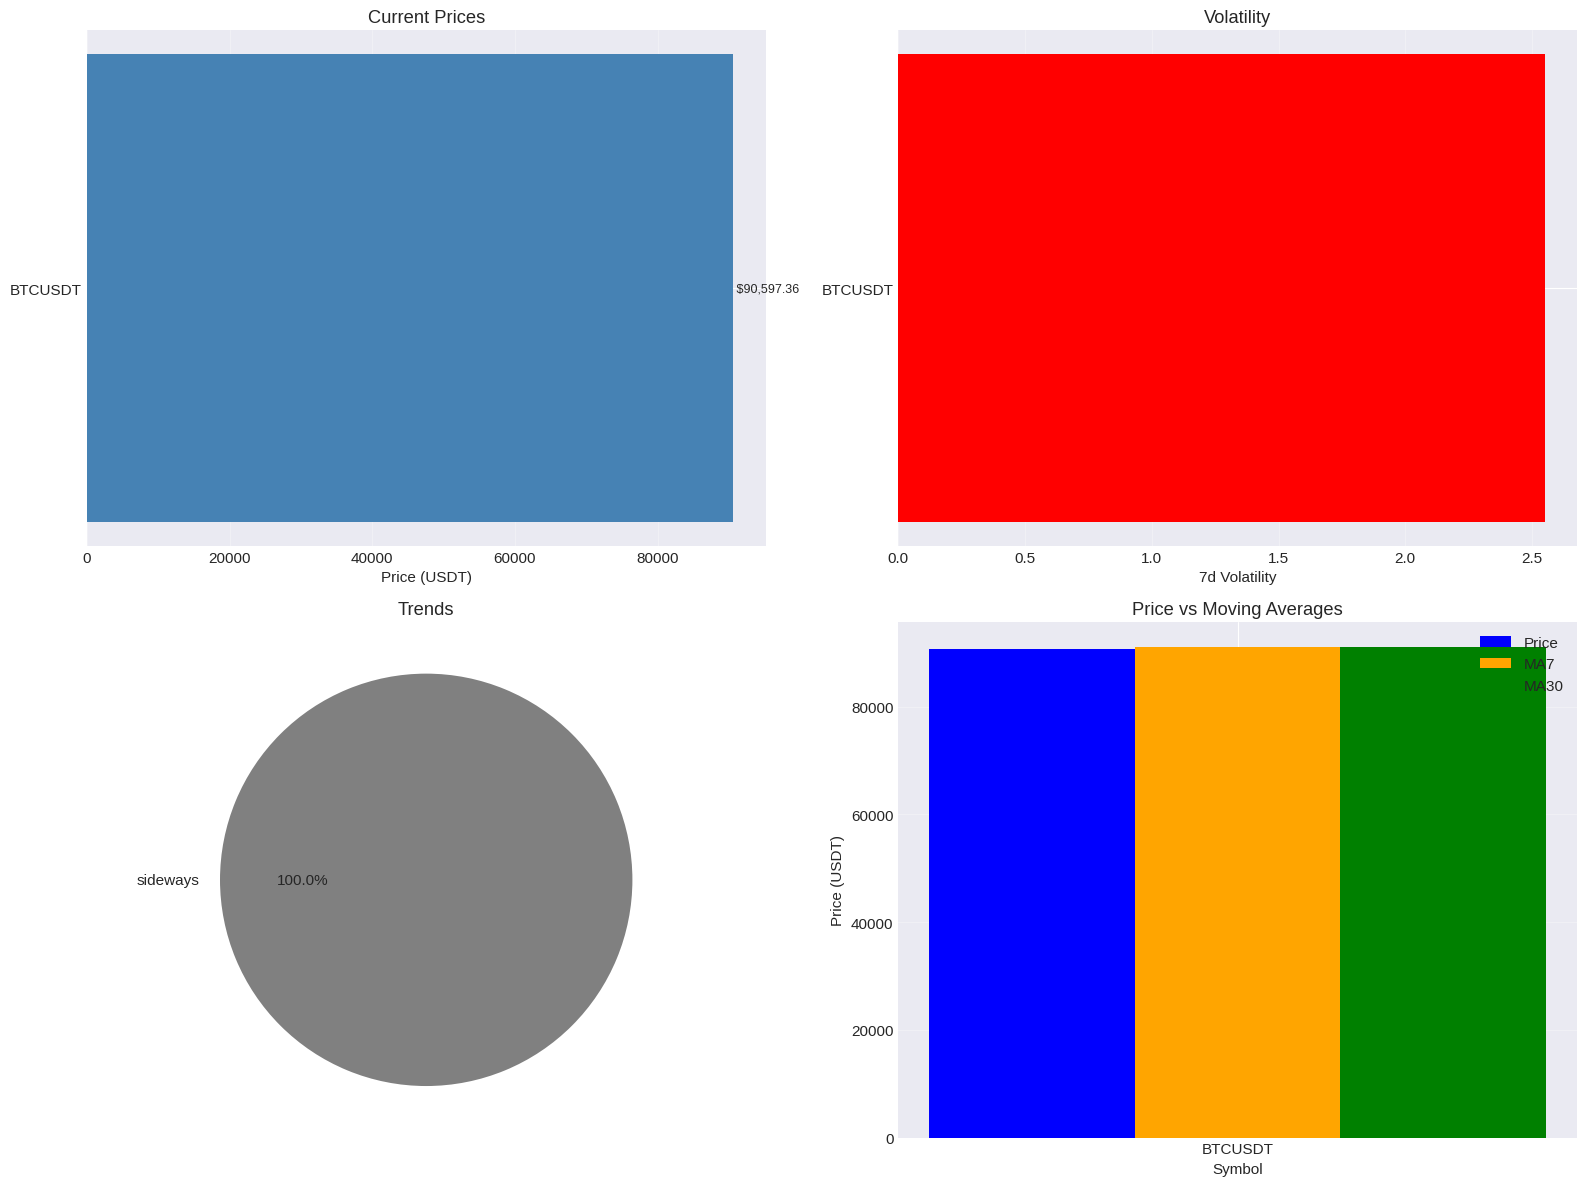


Current state:

BTCUSDT:
  Price: $90,597.36
  Trend: sideways
  Volatility: 2.5500
  MA7: $91,126.39, MA30: $91,126.39


In [5]:
if len(market_overview) > 0:
    latest_market = market_overview.sort_values('date').groupby('symbol').tail(1)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Prices
    ax1 = axes[0, 0]
    ax1.barh(latest_market['symbol'], latest_market['current_price'], color='steelblue')
    ax1.set_xlabel('Price (USDT)')
    ax1.set_title('Current Prices')
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (price, symbol) in enumerate(zip(latest_market['current_price'], latest_market['symbol'])):
        ax1.text(price, i, f' ${price:,.2f}', va='center', fontsize=9)
    
    # Volatility
    ax2 = axes[0, 1]
    colors = ['red' if v > 0.05 else 'orange' if v > 0.03 else 'green' 
              for v in latest_market['volatility_7d']]
    ax2.barh(latest_market['symbol'], latest_market['volatility_7d'], color=colors)
    ax2.set_xlabel('7d Volatility')
    ax2.set_title('Volatility')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Trend distribution
    ax3 = axes[1, 0]
    trend_counts = latest_market['trend_indicator'].value_counts()
    colors_trend = {'uptrend': 'green', 'downtrend': 'red', 'sideways': 'gray'}
    ax3.pie(trend_counts.values, labels=trend_counts.index, autopct='%1.1f%%',
            colors=[colors_trend.get(t, 'blue') for t in trend_counts.index])
    ax3.set_title('Trends')
    
    # Price vs MA
    ax4 = axes[1, 1]
    x = np.arange(len(latest_market))
    width = 0.25
    ax4.bar(x - width, latest_market['current_price'], width, label='Price', color='blue')
    ax4.bar(x, latest_market['ma_7d'], width, label='MA7', color='orange')
    ax4.bar(x + width, latest_market['ma_30d'], width, label='MA30', color='green')
    ax4.set_xlabel('Symbol')
    ax4.set_ylabel('Price (USDT)')
    ax4.set_title('Price vs Moving Averages')
    ax4.set_xticks(x)
    ax4.set_xticklabels(latest_market['symbol'])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    print("\nCurrent state:")
    for idx, row in latest_market.iterrows():
        print(f"\n{row['symbol']}:")
        print(f"  Price: ${row['current_price']:,.2f}")
        print(f"  Trend: {row['trend_indicator']}")
        print(f"  Volatility: {row['volatility_7d']:.4f}")
        print(f"  MA7: ${row['ma_7d']:,.2f}, MA30: ${row['ma_30d']:,.2f}")
else:
    print("No market data")

## Viz 2: Sentiment distribution

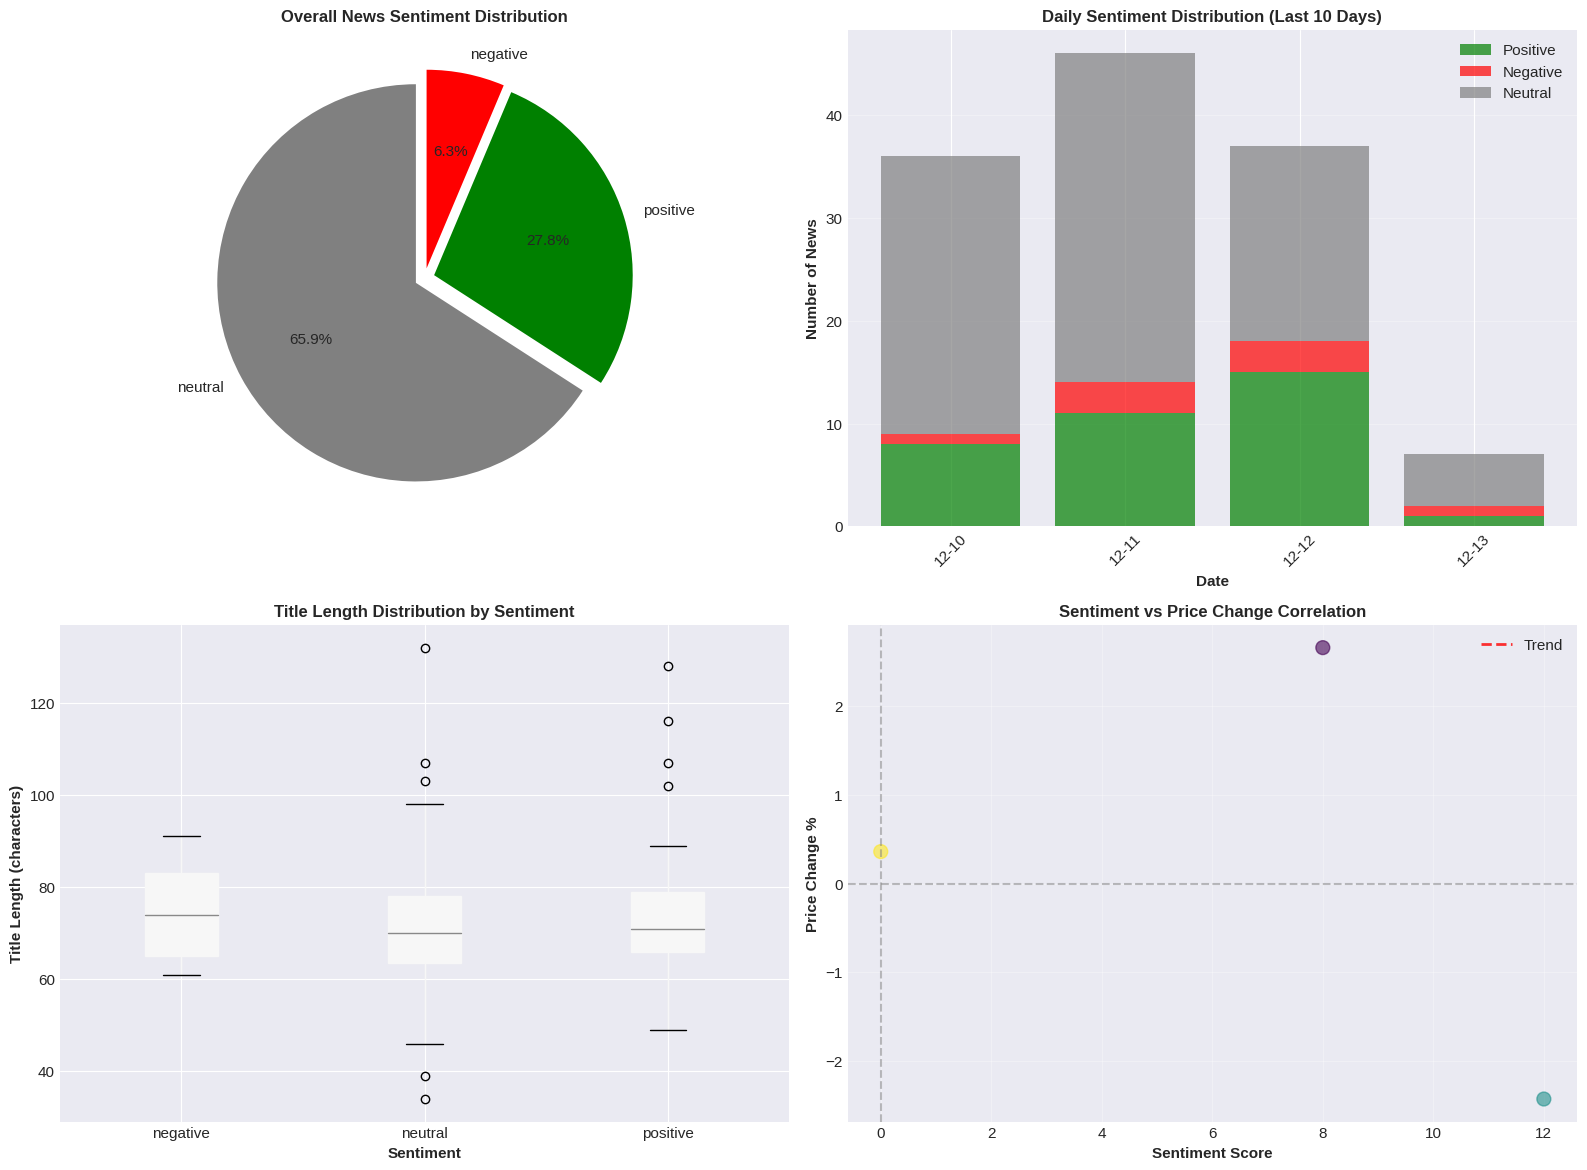


📊 SENTIMENT ANALYSIS INSIGHTS:

   Всего проанализировано новостей: 126
   ⚪ Neutral: 83 (65.9%)
   🟢 Positive: 35 (27.8%)
   🔴 Negative: 8 (6.3%)

   📈 Дней с положительной корреляцией: 1 (25.0%)
   📉 Дней с отрицательной корреляцией: 1 (25.0%)
   ➖ Дней без корреляции: 2 (50.0%)

   ⚠️ Sentiment новостей слабо связан с движением цен


In [6]:
if len(news_enriched) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Общее распределение sentiment
    ax1 = axes[0, 0]
    sentiment_counts = news_enriched['sentiment'].value_counts()
    colors_sent = {'positive': 'green', 'negative': 'red', 'neutral': 'gray'}
    ax1.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=[colors_sent.get(s, 'blue') for s in sentiment_counts.index],
            startangle=90, explode=[0.05]*len(sentiment_counts))
    ax1.set_title('Overall News Sentiment Distribution', fontsize=12, fontweight='bold')
    
    # 2. Sentiment по дням (топ-10 последних дней)
    ax2 = axes[0, 1]
    daily_sentiment = news_enriched.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
    daily_sentiment = daily_sentiment.sort_index(ascending=False).head(10).sort_index()
    
    if 'positive' in daily_sentiment.columns:
        ax2.bar(range(len(daily_sentiment)), daily_sentiment['positive'], 
                label='Positive', color='green', alpha=0.7)
    bottom = daily_sentiment.get('positive', 0)
    if 'negative' in daily_sentiment.columns:
        ax2.bar(range(len(daily_sentiment)), daily_sentiment['negative'],
                bottom=bottom, label='Negative', color='red', alpha=0.7)
        bottom = bottom + daily_sentiment['negative']
    if 'neutral' in daily_sentiment.columns:
        ax2.bar(range(len(daily_sentiment)), daily_sentiment['neutral'],
                bottom=bottom, label='Neutral', color='gray', alpha=0.7)
    
    ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of News', fontsize=11, fontweight='bold')
    ax2.set_title('Daily Sentiment Distribution (Last 10 Days)', fontsize=12, fontweight='bold')
    ax2.set_xticks(range(len(daily_sentiment)))
    ax2.set_xticklabels([d.strftime('%m-%d') for d in daily_sentiment.index], rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Длина заголовков по sentiment
    ax3 = axes[1, 0]
    news_enriched.boxplot(column='title_length', by='sentiment', ax=ax3, patch_artist=True)
    ax3.set_xlabel('Sentiment', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Title Length (characters)', fontsize=11, fontweight='bold')
    ax3.set_title('Title Length Distribution by Sentiment', fontsize=12, fontweight='bold')
    plt.suptitle('')
    
    # 4. Sentiment vs Price Change (если данные доступны)
    ax4 = axes[1, 1]
    if len(news_impact) > 0:
        # Агрегация по датам
        news_agg = news_impact.groupby('date').agg({
            'avg_sentiment_score': 'mean',
            'avg_price_change_pct': 'mean'
        }).reset_index().sort_values('date')
        
        ax4.scatter(news_agg['avg_sentiment_score'], news_agg['avg_price_change_pct'],
                   s=100, alpha=0.6, c=range(len(news_agg)), cmap='viridis')
        
        # Линия тренда
        if len(news_agg) > 1:
            z = np.polyfit(news_agg['avg_sentiment_score'], news_agg['avg_price_change_pct'], 1)
            p = np.poly1d(z)
            ax4.plot(news_agg['avg_sentiment_score'], 
                    p(news_agg['avg_sentiment_score']), 
                    "r--", alpha=0.8, linewidth=2, label='Trend')
        
        ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Sentiment Score', fontsize=11, fontweight='bold')
        ax4.set_ylabel('Price Change %', fontsize=11, fontweight='bold')
        ax4.set_title('Sentiment vs Price Change Correlation', fontsize=12, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        ax4.legend()
    else:
        ax4.text(0.5, 0.5, 'No correlation data available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Sentiment vs Price Change (No Data)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Инсайты
    print("\n📊 SENTIMENT ANALYSIS INSIGHTS:")
    total = len(news_enriched)
    print(f"\n   Всего проанализировано новостей: {total}")
    for sentiment, count in sentiment_counts.items():
        emoji = {'positive': '🟢', 'negative': '🔴', 'neutral': '⚪'}.get(sentiment, '•')
        print(f"   {emoji} {sentiment.capitalize()}: {count} ({count/total*100:.1f}%)")
    
    if len(news_impact) > 0:
        positive_corr = (news_impact['sentiment_price_correlation'] == 'positive_correlation').sum()
        negative_corr = (news_impact['sentiment_price_correlation'] == 'negative_correlation').sum()
        no_corr = (news_impact['sentiment_price_correlation'] == 'no_correlation').sum()
        total_days = len(news_impact)
        
        print(f"\n   📈 Дней с положительной корреляцией: {positive_corr} ({positive_corr/total_days*100:.1f}%)")
        print(f"   📉 Дней с отрицательной корреляцией: {negative_corr} ({negative_corr/total_days*100:.1f}%)")
        print(f"   ➖ Дней без корреляции: {no_corr} ({no_corr/total_days*100:.1f}%)")
        
        if positive_corr > total_days / 2:
            print("\n   ✅ Sentiment новостей преимущественно коррелирует с движением цен")
        else:
            print("\n   ⚠️ Sentiment новостей слабо связан с движением цен")
else:
    print("⚠️ Нет данных по новостям")

## Viz 3: Candlestick chart

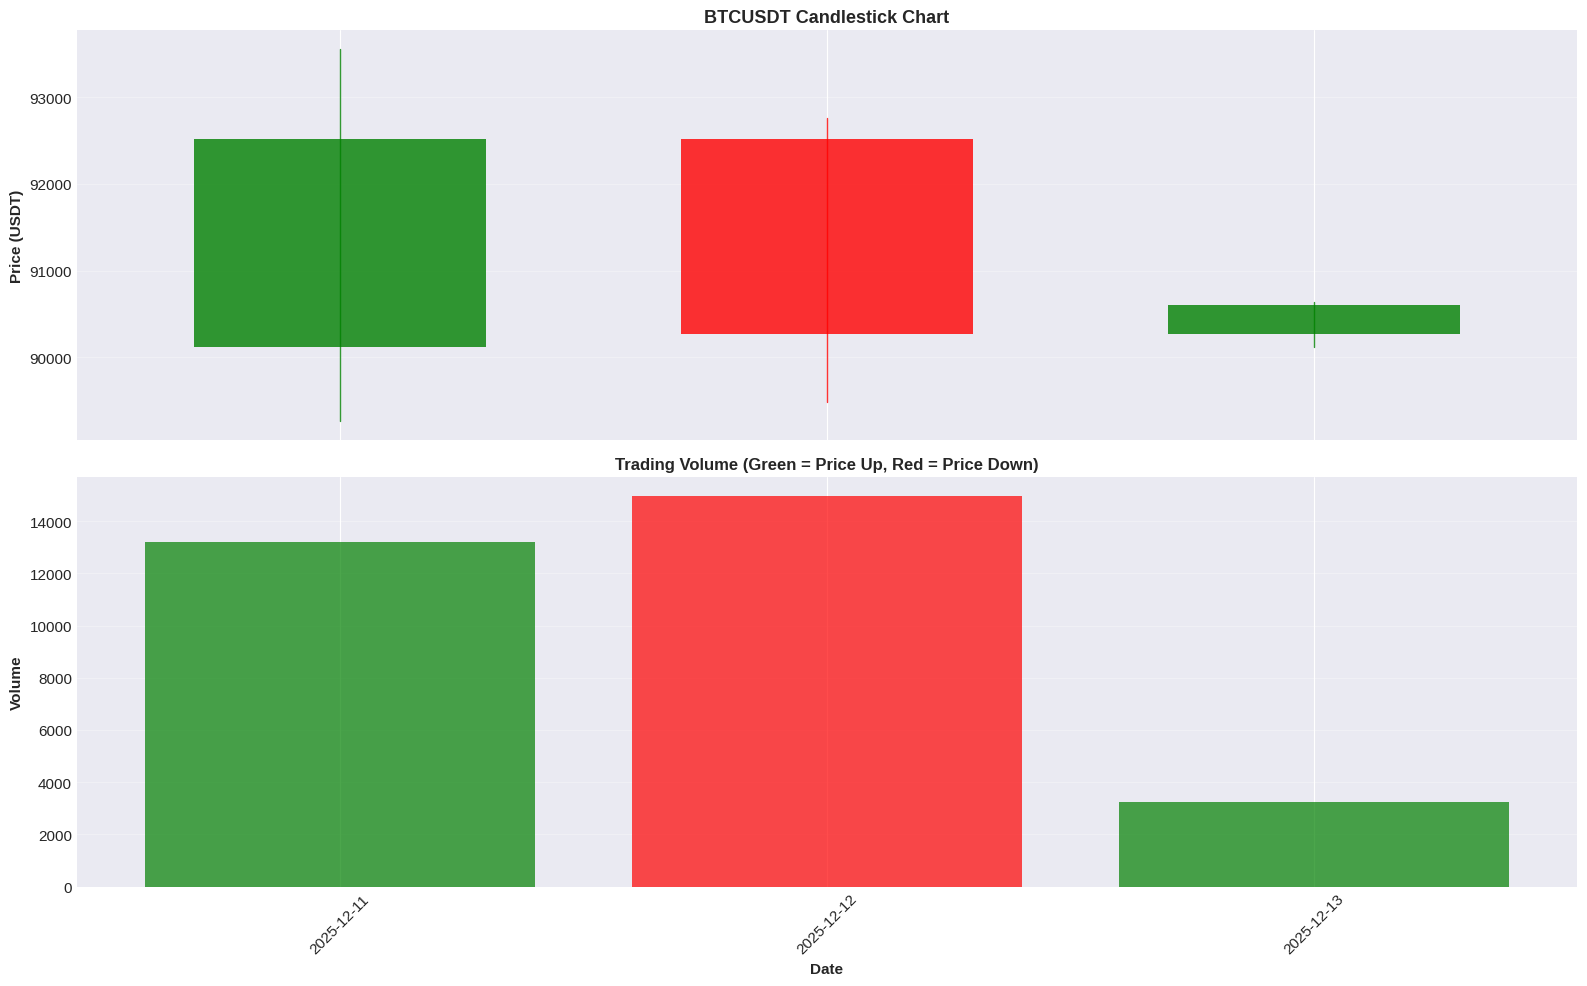


📊 CANDLESTICK ANALYSIS для BTCUSDT:

   Период: 2025-12-11 → 2025-12-13
   Всего торговых дней: 3

   💰 Цены:
      Минимум: $89,260.63
      Максимум: $93,555.00
      Текущая: $90,597.36

   📈 Торговые дни:
      Зеленые (рост): 2 (66.7%)
      Красные (падение): 1 (33.3%)

   📊 Изменения цен:
      Среднее изменение за день: 1.82%
      Максимальный рост: 2.66%
      Максимальное падение: -2.43%

   📦 Объемы:
      Средний: 10,464
      Максимальный: 14,952 (дата: 2025-12-12)


In [7]:
if len(daily_agg) > 0:
    # Взять данные для первого доступного символа
    symbols_available = daily_agg['symbol'].unique()
    selected_symbol = symbols_available[0]
    
    candle_data = daily_agg[daily_agg['symbol'] == selected_symbol].sort_values('date')
    
    if len(candle_data) > 0:
        fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
        
        # График 1: Candlestick
        ax1 = axes[0]
        
        up = candle_data[candle_data['close_price'] >= candle_data['open_price']]
        down = candle_data[candle_data['close_price'] < candle_data['open_price']]
        
        # Зеленые свечи (рост)
        for idx, row in up.iterrows():
            x_pos = list(candle_data.index).index(idx)
            # Тело свечи
            ax1.bar(x_pos, row['close_price'] - row['open_price'], 
                   bottom=row['open_price'], color='green', alpha=0.8, width=0.6)
            # Тени
            ax1.plot([x_pos, x_pos], [row['low_price'], row['high_price']], 
                    color='green', linewidth=1, alpha=0.8)
        
        # Красные свечи (падение)
        for idx, row in down.iterrows():
            x_pos = list(candle_data.index).index(idx)
            # Тело свечи
            ax1.bar(x_pos, row['open_price'] - row['close_price'], 
                   bottom=row['close_price'], color='red', alpha=0.8, width=0.6)
            # Тени
            ax1.plot([x_pos, x_pos], [row['low_price'], row['high_price']], 
                    color='red', linewidth=1, alpha=0.8)
        
        ax1.set_ylabel('Price (USDT)', fontsize=11, fontweight='bold')
        ax1.set_title(f'{selected_symbol} Candlestick Chart', fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # График 2: Объем торгов
        ax2 = axes[1]
        colors = ['green' if row['close_price'] >= row['open_price'] else 'red' 
                 for idx, row in candle_data.iterrows()]
        ax2.bar(range(len(candle_data)), candle_data['total_volume'], 
               color=colors, alpha=0.7)
        ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Volume', fontsize=11, fontweight='bold')
        ax2.set_title('Trading Volume (Green = Price Up, Red = Price Down)', 
                     fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # X-axis labels
        ax2.set_xticks(range(len(candle_data)))
        ax2.set_xticklabels([d.strftime('%Y-%m-%d') for d in candle_data['date']], 
                           rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Инсайты
        print(f"\n📊 CANDLESTICK ANALYSIS для {selected_symbol}:")
        print(f"\n   Период: {candle_data['date'].min()} → {candle_data['date'].max()}")
        print(f"   Всего торговых дней: {len(candle_data)}")
        print(f"\n   💰 Цены:")
        print(f"      Минимум: ${candle_data['low_price'].min():,.2f}")
        print(f"      Максимум: ${candle_data['high_price'].max():,.2f}")
        print(f"      Текущая: ${candle_data.iloc[-1]['close_price']:,.2f}")
        
        up_days = len(up)
        down_days = len(down)
        print(f"\n   📈 Торговые дни:")
        print(f"      Зеленые (рост): {up_days} ({up_days/len(candle_data)*100:.1f}%)")
        print(f"      Красные (падение): {down_days} ({down_days/len(candle_data)*100:.1f}%)")
        
        # Price change analysis
        max_gain = candle_data['price_change_pct'].max()
        max_loss = candle_data['price_change_pct'].min()
        avg_change = abs(candle_data['price_change_pct']).mean()
        print(f"\n   📊 Изменения цен:")
        print(f"      Среднее изменение за день: {avg_change:.2f}%")
        print(f"      Максимальный рост: {max_gain:.2f}%")
        print(f"      Максимальное падение: {max_loss:.2f}%")
        
        # Volume analysis
        avg_volume = candle_data['total_volume'].mean()
        max_volume = candle_data['total_volume'].max()
        max_volume_date = candle_data[candle_data['total_volume'] == max_volume]['date'].iloc[0]
        print(f"\n   📦 Объемы:")
        print(f"      Средний: {avg_volume:,.0f}")
        print(f"      Максимальный: {max_volume:,.0f} (дата: {max_volume_date})")
    else:
        print(f"⚠️ Нет данных для {selected_symbol}")
else:
    print("⚠️ Нет OHLC данных")

## Viz 4: Correlation heatmap


Correlation analysis:


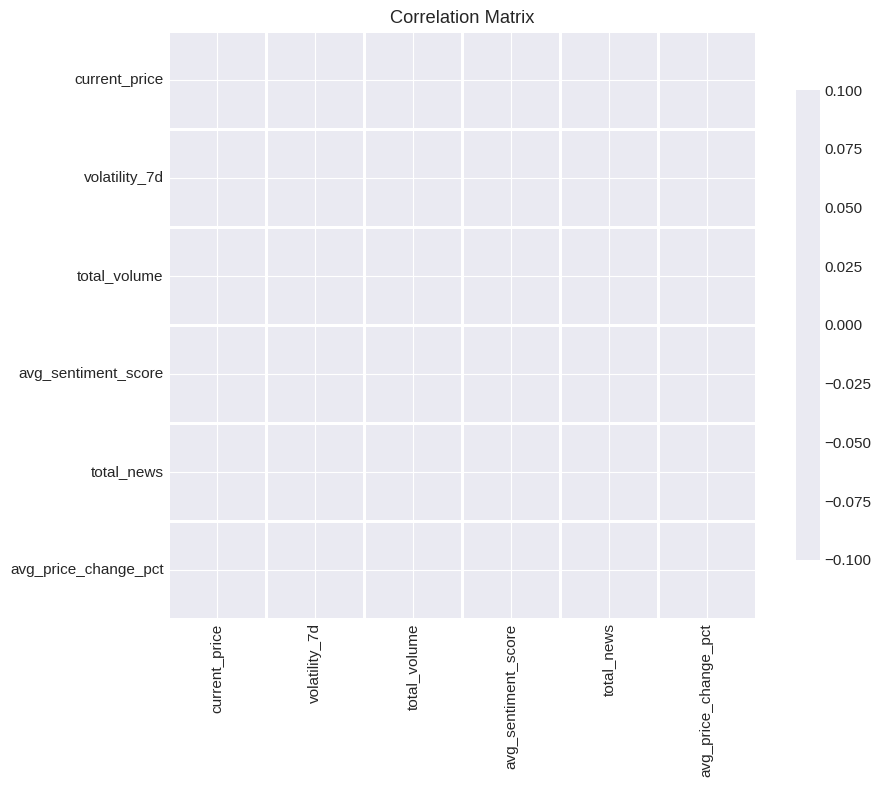


Strong correlations (|r| > 0.5):
  None found

Moderate correlations (0.3 < |r| < 0.5):
  None found

Sentiment correlations:
  Sentiment <-> Price: nan
  Sentiment <-> Price change: nan

Symbols analyzed: 1


In [8]:
# Корреляции между метриками
print("\nCorrelation analysis:")

if len(market_overview) > 0 and len(news_impact) > 0:
    # Агрегируем по символам
    market_agg = market_overview.groupby('symbol').agg({
        'current_price': 'mean',
        'volatility_7d': 'mean',
        'total_volume': 'mean'
    }).reset_index()
    
    news_agg = news_impact.groupby('symbol').agg({
        'avg_sentiment_score': 'mean',
        'total_news': 'sum',
        'avg_price_change_pct': 'mean'
    }).reset_index()
    
    combined_data = pd.merge(market_agg, news_agg, on='symbol', how='inner')
    
    if len(combined_data) > 0:
        correlation_matrix = combined_data[[
            'current_price', 'volatility_7d', 'total_volume',
            'avg_sentiment_score', 'total_news', 'avg_price_change_pct'
        ]].corr()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
        ax.set_title('Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        print("\nStrong correlations (|r| > 0.5):")
        found = False
        for i in range(len(correlation_matrix)):
            for j in range(i+1, len(correlation_matrix)):
                corr_value = correlation_matrix.iloc[i, j]
                if abs(corr_value) > 0.5:
                    col1 = correlation_matrix.index[i]
                    col2 = correlation_matrix.columns[j]
                    print(f"  {col1} <-> {col2}: {corr_value:.3f}")
                    found = True
        if not found:
            print("  None found")
        
        print("\nModerate correlations (0.3 < |r| < 0.5):")
        found = False
        for i in range(len(correlation_matrix)):
            for j in range(i+1, len(correlation_matrix)):
                corr_value = correlation_matrix.iloc[i, j]
                if 0.3 < abs(corr_value) <= 0.5:
                    col1 = correlation_matrix.index[i]
                    col2 = correlation_matrix.columns[j]
                    print(f"  {col1} <-> {col2}: {corr_value:.3f}")
                    found = True
        if not found:
            print("  None found")
        
        # Sentiment analysis
        if 'avg_sentiment_score' in correlation_matrix.columns:
            print("\nSentiment correlations:")
            if 'current_price' in correlation_matrix.columns:
                r = correlation_matrix.loc['avg_sentiment_score', 'current_price']
                print(f"  Sentiment <-> Price: {r:.3f}")
            if 'avg_price_change_pct' in correlation_matrix.columns:
                r = correlation_matrix.loc['avg_sentiment_score', 'avg_price_change_pct']
                print(f"  Sentiment <-> Price change: {r:.3f}")
        
        print(f"\nSymbols analyzed: {len(combined_data)}")
    else:
        print("No common data between market and news")
else:
    print("Not enough data")

## 8. Визуализация 5: Time Series Patterns (если доступны)

**Инсайт**: Временные паттерны в ценах и новостях.

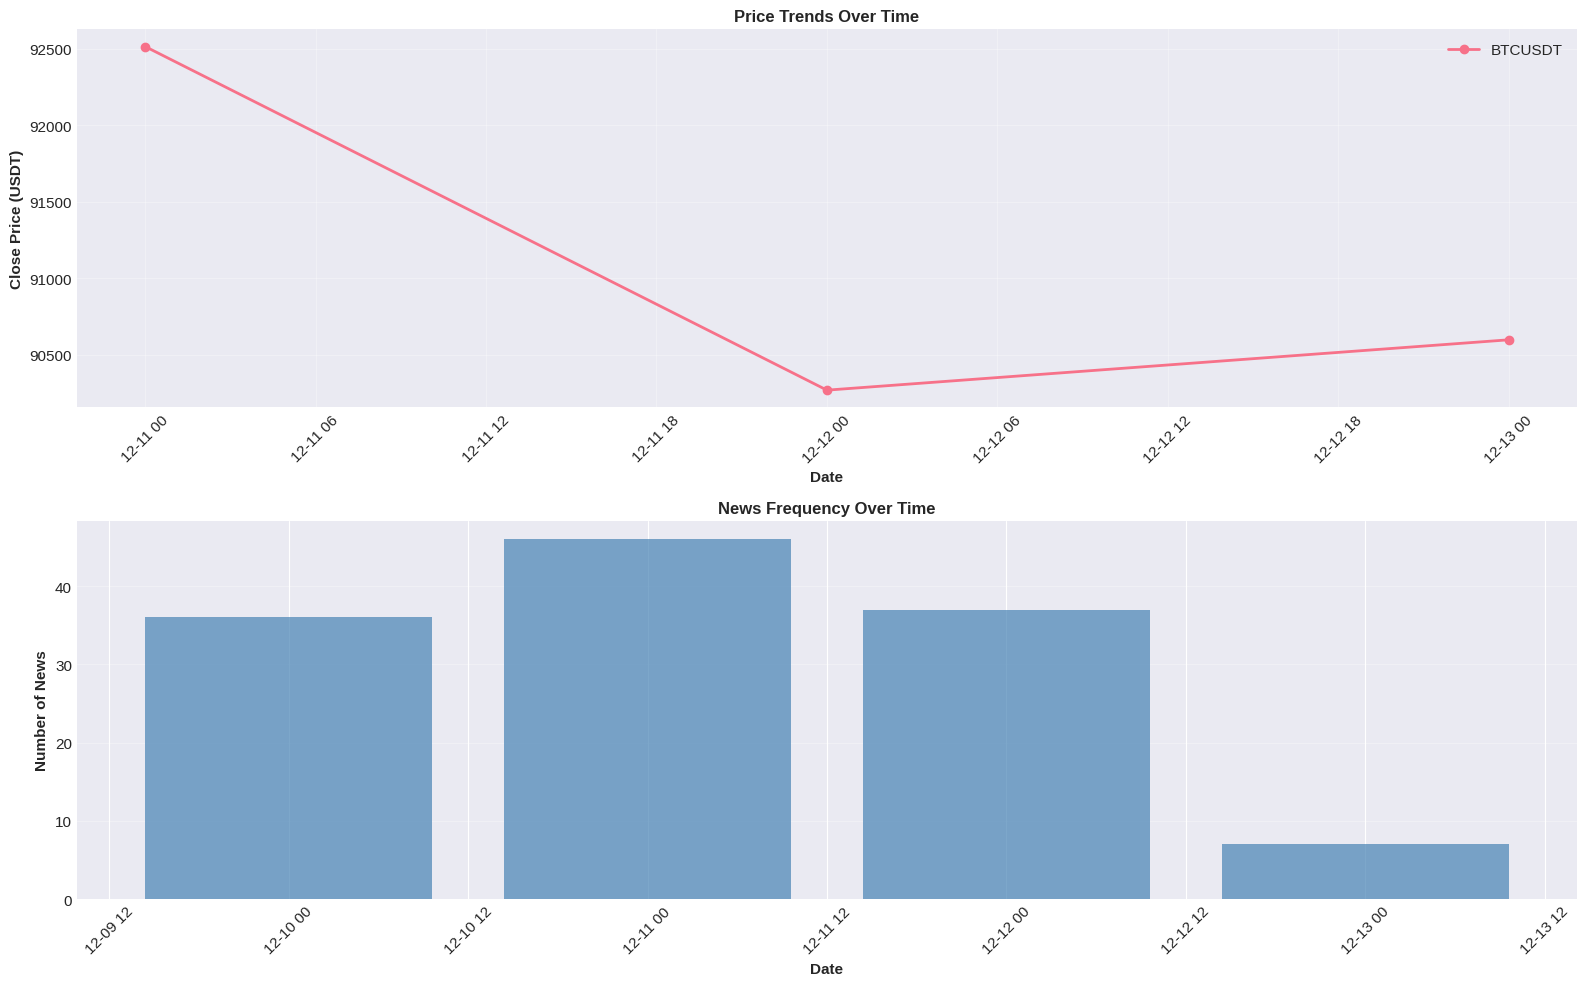


📊 TIME SERIES INSIGHTS:

   📈 Доступно 3 торговых дней
   📅 Период: 2025-12-11 → 2025-12-13

   📰 Среднее количество новостей в день: 31.5


In [9]:
if len(daily_agg) > 1 or len(news_enriched) > 10:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # График 1: Price trends
    ax1 = axes[0]
    if len(daily_agg) > 1:
        for symbol in daily_agg['symbol'].unique():
            symbol_data = daily_agg[daily_agg['symbol'] == symbol].sort_values('date')
            ax1.plot(symbol_data['date'], symbol_data['close_price'], 
                    marker='o', label=symbol, linewidth=2)
        
        ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Close Price (USDT)', fontsize=11, fontweight='bold')
        ax1.set_title('Price Trends Over Time', fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax1.text(0.5, 0.5, 'Insufficient price data for time series', 
                ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    
    # График 2: News frequency over time
    ax2 = axes[1]
    if len(news_enriched) > 10:
        news_daily_count = news_enriched.groupby('date').size().reset_index(name='count')
        news_daily_count = news_daily_count.sort_values('date')
        
        ax2.bar(news_daily_count['date'], news_daily_count['count'], 
               alpha=0.7, color='steelblue')
        ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Number of News', fontsize=11, fontweight='bold')
        ax2.set_title('News Frequency Over Time', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    else:
        ax2.text(0.5, 0.5, 'Insufficient news data for time series', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 TIME SERIES INSIGHTS:")
    if len(daily_agg) > 1:
        print(f"\n   📈 Доступно {len(daily_agg)} торговых дней")
        print(f"   📅 Период: {daily_agg['date'].min()} → {daily_agg['date'].max()}")
    
    if len(news_enriched) > 10:
        news_per_day = len(news_enriched) / news_enriched['date'].nunique()
        print(f"\n   📰 Среднее количество новостей в день: {news_per_day:.1f}")
else:
    print("⚠️ Недостаточно данных для построения временных рядов")
    print("   Для полноценного анализа рекомендуется собрать данные за больший период")

## 9. Визуализация 6: Summary Dashboard

**Инсайт**: Сводная панель с ключевыми метриками.

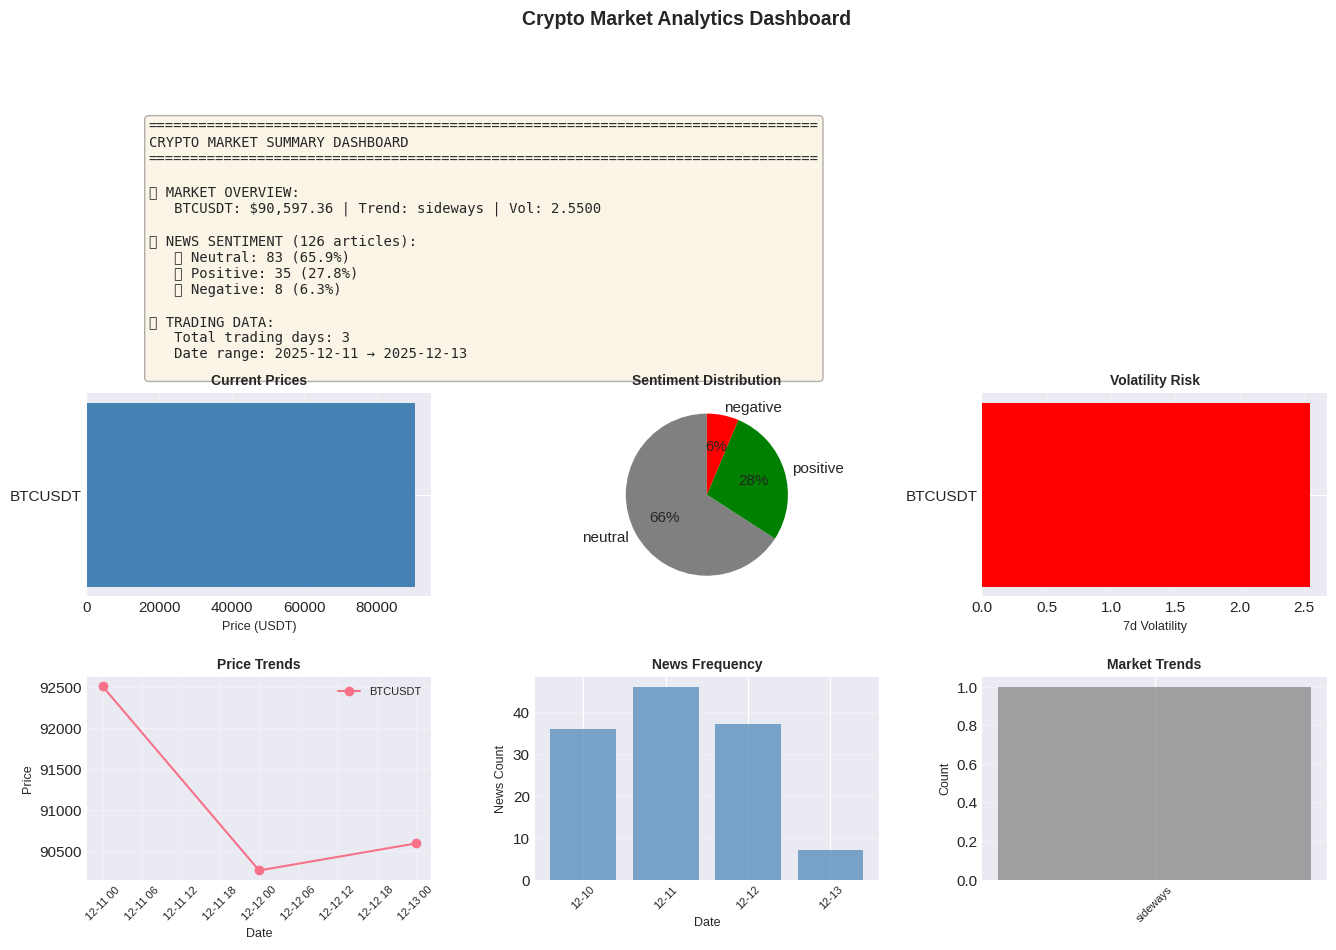


Dashboard generated successfully!


In [10]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

# 1. Ключевые метрики (текст)
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

metrics_text = "=" * 80 + "\n"
metrics_text += "CRYPTO MARKET SUMMARY DASHBOARD\n"
metrics_text += "=" * 80 + "\n\n"

if len(market_overview) > 0:
    latest = market_overview.sort_values('date').groupby('symbol').tail(1)
    metrics_text += "📊 MARKET OVERVIEW:\n"
    for idx, row in latest.iterrows():
        metrics_text += f"   {row['symbol']}: ${row['current_price']:,.2f} | "
        metrics_text += f"Trend: {row['trend_indicator']} | Vol: {row['volatility_7d']:.4f}\n"

if len(news_enriched) > 0:
    sentiment_dist = news_enriched['sentiment'].value_counts()
    total_news = len(news_enriched)
    metrics_text += f"\n📰 NEWS SENTIMENT ({total_news} articles):\n"
    for sent, count in sentiment_dist.items():
        emoji = {'positive': '🟢', 'negative': '🔴', 'neutral': '⚪'}.get(sent, '•')
        metrics_text += f"   {emoji} {sent.capitalize()}: {count} ({count/total_news*100:.1f}%)\n"

if len(daily_agg) > 0:
    metrics_text += f"\n📈 TRADING DATA:\n"
    metrics_text += f"   Total trading days: {len(daily_agg)}\n"
    metrics_text += f"   Date range: {daily_agg['date'].min()} → {daily_agg['date'].max()}\n"

ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 2-4. Мини-графики
if len(market_overview) > 0:
    # Current prices
    ax2 = fig.add_subplot(gs[1, 0])
    latest = market_overview.sort_values('date').groupby('symbol').tail(1)
    ax2.barh(latest['symbol'], latest['current_price'], color='steelblue')
    ax2.set_xlabel('Price (USDT)', fontsize=9)
    ax2.set_title('Current Prices', fontsize=10, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

if len(news_enriched) > 0:
    # Sentiment pie
    ax3 = fig.add_subplot(gs[1, 1])
    sentiment_counts = news_enriched['sentiment'].value_counts()
    colors_sent = [{'positive': 'green', 'negative': 'red', 'neutral': 'gray'}.get(s, 'blue') 
                  for s in sentiment_counts.index]
    ax3.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.0f%%',
           colors=colors_sent, startangle=90)
    ax3.set_title('Sentiment Distribution', fontsize=10, fontweight='bold')

if len(market_overview) > 0:
    # Volatility
    ax4 = fig.add_subplot(gs[1, 2])
    latest = market_overview.sort_values('date').groupby('symbol').tail(1)
    colors_vol = ['red' if v > 0.05 else 'orange' if v > 0.03 else 'green' 
                 for v in latest['volatility_7d']]
    ax4.barh(latest['symbol'], latest['volatility_7d'], color=colors_vol)
    ax4.set_xlabel('7d Volatility', fontsize=9)
    ax4.set_title('Volatility Risk', fontsize=10, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

# 5-7. Bottom row
if len(daily_agg) > 0:
    # Price trend
    ax5 = fig.add_subplot(gs[2, 0])
    for symbol in daily_agg['symbol'].unique()[:3]:  # Max 3 symbols
        symbol_data = daily_agg[daily_agg['symbol'] == symbol].sort_values('date')
        ax5.plot(symbol_data['date'], symbol_data['close_price'], 
                marker='o', label=symbol, linewidth=1.5)
    ax5.set_xlabel('Date', fontsize=9)
    ax5.set_ylabel('Price', fontsize=9)
    ax5.set_title('Price Trends', fontsize=10, fontweight='bold')
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, fontsize=8)

if len(news_enriched) > 5:
    # News frequency
    ax6 = fig.add_subplot(gs[2, 1])
    news_daily = news_enriched.groupby('date').size().reset_index(name='count')
    news_daily = news_daily.sort_values('date').tail(10)
    ax6.bar(range(len(news_daily)), news_daily['count'], color='steelblue', alpha=0.7)
    ax6.set_xlabel('Date', fontsize=9)
    ax6.set_ylabel('News Count', fontsize=9)
    ax6.set_title('News Frequency', fontsize=10, fontweight='bold')
    ax6.set_xticks(range(len(news_daily)))
    ax6.set_xticklabels([d.strftime('%m-%d') for d in news_daily['date']], 
                       rotation=45, fontsize=8)
    ax6.grid(True, alpha=0.3, axis='y')

if len(market_overview) > 0:
    # Trend distribution
    ax7 = fig.add_subplot(gs[2, 2])
    trend_counts = market_overview['trend_indicator'].value_counts()
    colors_trend = [{'uptrend': 'green', 'downtrend': 'red', 'sideways': 'gray'}.get(t, 'blue') 
                   for t in trend_counts.index]
    ax7.bar(range(len(trend_counts)), trend_counts.values, color=colors_trend, alpha=0.7)
    ax7.set_xticks(range(len(trend_counts)))
    ax7.set_xticklabels(trend_counts.index, rotation=45, fontsize=8)
    ax7.set_ylabel('Count', fontsize=9)
    ax7.set_title('Market Trends', fontsize=10, fontweight='bold')
    ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('Crypto Market Analytics Dashboard', fontsize=14, fontweight='bold', y=0.98)
plt.show()

print("\n" + "="*80)
print("Dashboard generated successfully!")
print("="*80)

## 10. Итоговые выводы и рекомендации

In [11]:
print("="*60)
print("SUMMARY")
print("="*60)

print("\nSentiment method:")
print("  Keyword-based in DBT (bull/bear words)")
print("  Simple but works for quick analysis")

print("\nMarket trends:")
if len(market_overview) > 0:
    trend_dist = market_overview['trend_indicator'].value_counts()
    for trend, count in trend_dist.items():
        print(f"  {trend}: {count} symbols")

print("\nVolatility:")
if len(market_overview) > 0:
    vol_stats = market_overview.groupby('symbol')['volatility_7d'].mean().sort_values(ascending=False)
    for symbol, vol in vol_stats.items():
        risk = "high" if vol > 0.05 else "medium" if vol > 0.03 else "low"
        print(f"  {symbol}: {vol:.4f} ({risk} risk)")

print("\nNews impact:")
if len(news_impact) > 0:
    corr_stats = news_impact['sentiment_price_correlation'].value_counts()
    total = len(news_impact)
    for corr_type, count in corr_stats.items():
        pct = count / total * 100
        print(f"  {corr_type}: {count} days ({pct:.1f}%)")

print("\nPipeline:")
print("  FastAPI → MongoDB → Airflow → PostgreSQL → DBT → Analysis")
print("  Quality: Elementary tests (57 total)")

print("\n" + "="*60)

SUMMARY

Sentiment method:
  Keyword-based in DBT (bull/bear words)
  Simple but works for quick analysis

Market trends:
  sideways: 1 symbols

Volatility:
  BTCUSDT: 2.5500 (high risk)

News impact:
  no_correlation: 2 days (50.0%)
  negative_correlation: 1 days (25.0%)
  positive_correlation: 1 days (25.0%)

Pipeline:
  FastAPI → MongoDB → Airflow → PostgreSQL → DBT → Analysis
  Quality: Elementary tests (57 total)



## Summary

Проанализировали данные криптовалютного рынка через несколько визуализаций:

1. **Market snapshot** - текущие цены, волатильность, тренды
2. **Sentiment** - распределение новостей по тональности
3. **Candlestick** - OHLC графики с объемами
4. **Correlations** - взаимосвязи между метриками
5. **Time series** - динамика изменений
6. **Dashboard** - общая картина

**Sentiment analysis**: используется простой keyword matching в DBT (bull/bear слова)

**Pipeline**: FastAPI → MongoDB → Airflow EL → PostgreSQL → DBT (STG → ODS → DM) → Analysis

Все данные прошли тесты через Elementary.

In [12]:
conn.close()
print("Done")

Done
